---
**Chapter 09**
# **Advanced deep learning for computer vision**
---


In [2]:
# System Libraries
import importlib, sys, os
import numpy as np
import random

# TensorFlow Libraries
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
from tensorflow import keras
import tensorflow as tf

# User Libraries
sys.path.append("../")
from modules import common, chapter_01, chapter_09

# Reload Libraries
importlib.reload(chapter_01)
importlib.reload(chapter_09)
importlib.reload(common)

# Check GPU
print(tf.config.list_physical_devices())

# Module variables
batch_size = 64
epochs = 10

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
- Three essential computer vision tasks
- Image segmentation
- Modern convnet architecture patterns
  - Modularity, hierarchy, reuse
  - Residual connections
  - Batch normalizaton
  - Depthwise separable convolution
  - Mini Xception model
- Interpret what convnets learn
  - Visualize intermediate activations
  - Visualize convet filters
  - Visualize heatmaps of class acitvation
---

- Image classification
  - Assign one or more classes to an image
  - Single-label mutliclass classification
  - Multi-label classification
  - **Logit layer is Dense**
- Image segmentation
  - Semantic segmentation
    - Each pixel is independently classified into a segmentation cateogory
    - **Logit layer is Conv2D**
    - Example:
      - If there are two cats in an image, pixels of both will be mapped as **cat**
  - Instance segmentation
    - Each pixel is independently classified into a segmentation category
    - Parse out object instances
    - Example:
      - If there are two cats in an image, pixels will be mapped as **cat1** and **cat2**
  - Segmentation mask:
    - Single colour (0-255) label of an image where each integer represents a unique class
    - 1: Background, 2: Bottle 
- Object detection
  - RetinaNet: https://keras.io/examples/vision/retinanet

---
# **Image segmentation**
---

### <ins />**Dataset**

In [ ]:
img_size = (200, 200)
input_raw, input_imgs, labels, num_labels = chapter_09.dataset(img_size)

### <ins />**Exploration**

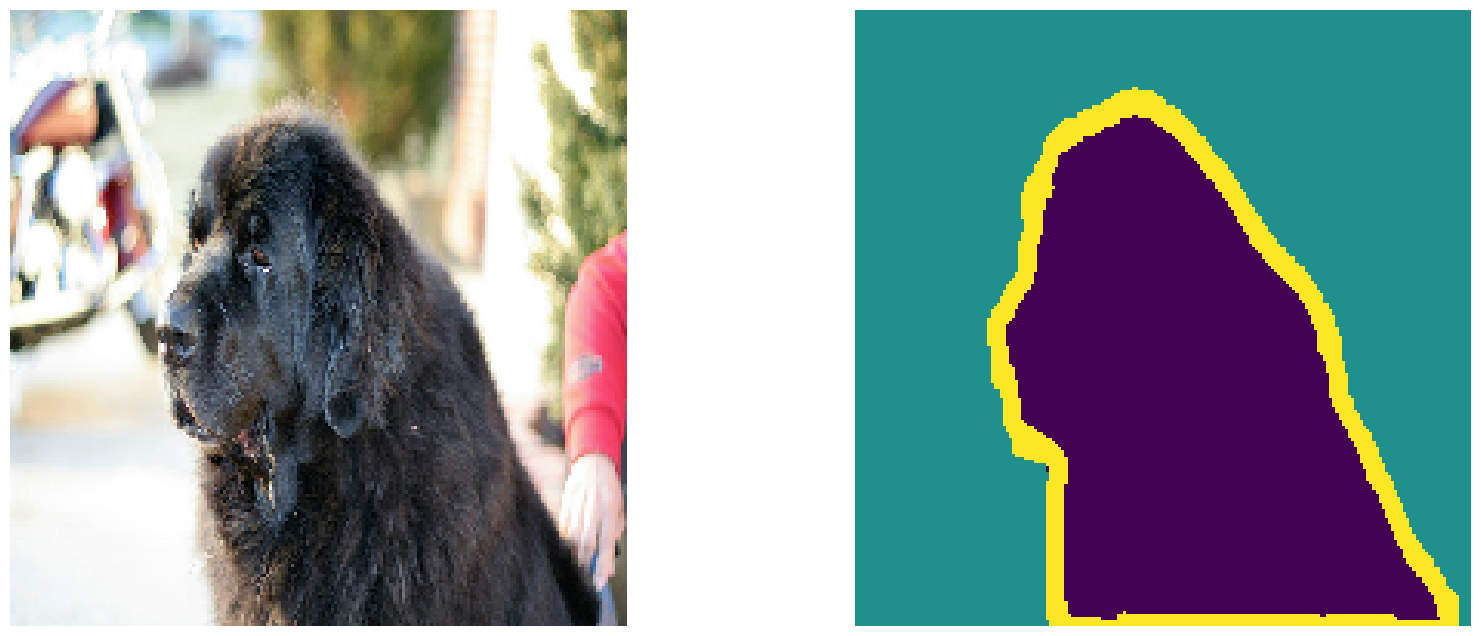

In [144]:
explore_idx = random.randint(0, num_labels)
chapter_09.explore(input_raw[explore_idx], labels[explore_idx])

### <ins />**Downsample and upsample**

**Downsample:**
- Encode images into smaller feature maps
- Conv2D

**Upsample:**
- To have shape of segmentation mask same as input image
- Conv2DTranspose

**Note:**
- For segmentation and detection, use stride instead of maxpooling

In [ ]:
input_dim = 3
inputs = keras.Input(shape=(120, 120, input_dim))
# Downsample the feature maps
downsample = keras.layers.Conv2D(filters=64, kernel_size=3)(inputs)
# Upsample the feature maps
upsample = keras.layers.Conv2DTranspose(filters=input_dim, kernel_size=3)(downsample)
model = keras.Model(inputs=inputs, outputs=upsample)
model.summary()

### <ins />**Model**

In [124]:
def get_model(input_size, num_classes):
    # -----------------------------------------
    # Input Layer
    # -----------------------------------------
    inputs = keras.Input(shape=input_size + (3,))
    x = keras.layers.Rescaling(1.0 / 255)(inputs)
    # -----------------------------------------
    # Downsampling Layers
    # -----------------------------------------
    x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    # -----------------------------------------
    # Upsampling Layers
    # -----------------------------------------
    x = keras.layers.Conv2DTranspose(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    x = keras.layers.Conv2DTranspose(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    x = keras.layers.Conv2DTranspose(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
    x = keras.layers.Conv2DTranspose(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2)(x)
    # -----------------------------------------
    # Output Layer
    # -----------------------------------------
    outputs = keras.layers.Conv2D(filters=num_classes, kernel_size=3, padding="same", activation=tf.nn.softmax)(x)
    # -----------------------------------------
    # Model
    # -----------------------------------------
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

### <ins />**Train**

In [ ]:
model = get_model(img_size=img_size, num_classes=3)
chapter_01.compile(model=model, metrics=None)
history = chapter_01.train(input_imgs, labels, model, 0.3, 64, callbacks=common.callbacks(), epochs=epochs)

### <ins />**Graph**

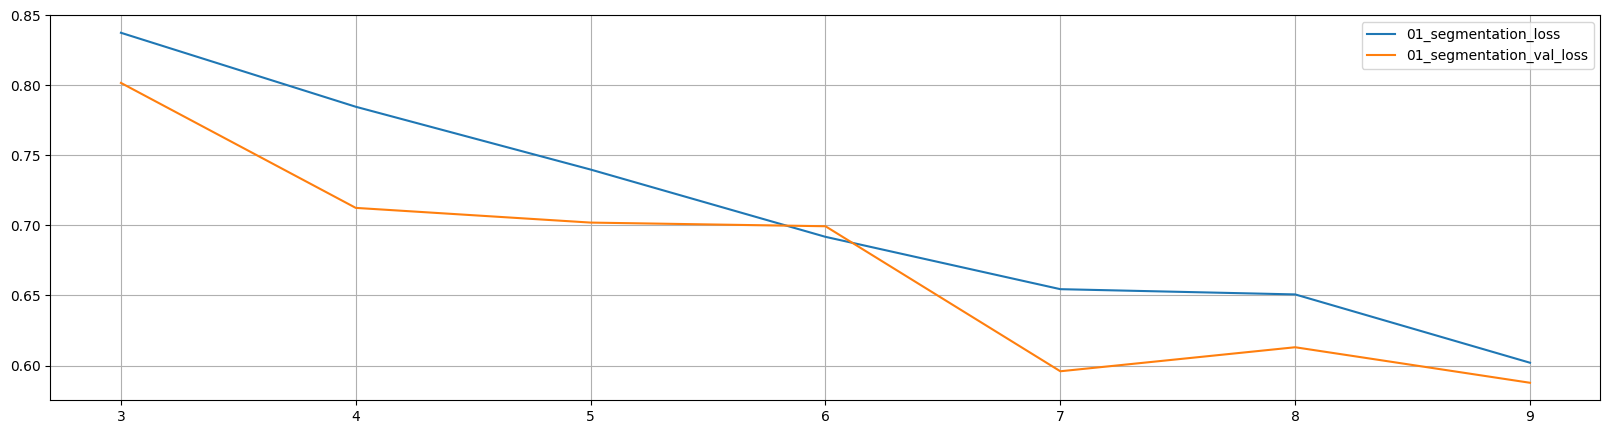

In [149]:
common.plot_simple(
    data=[history.history["loss"], history.history["val_loss"]],
    labels=["01_segmentation_loss", "01_segmentation_val_loss"],
    start_index=3,
)

### <ins />**Test**

1/1 [==============================] - 0s 16ms/step


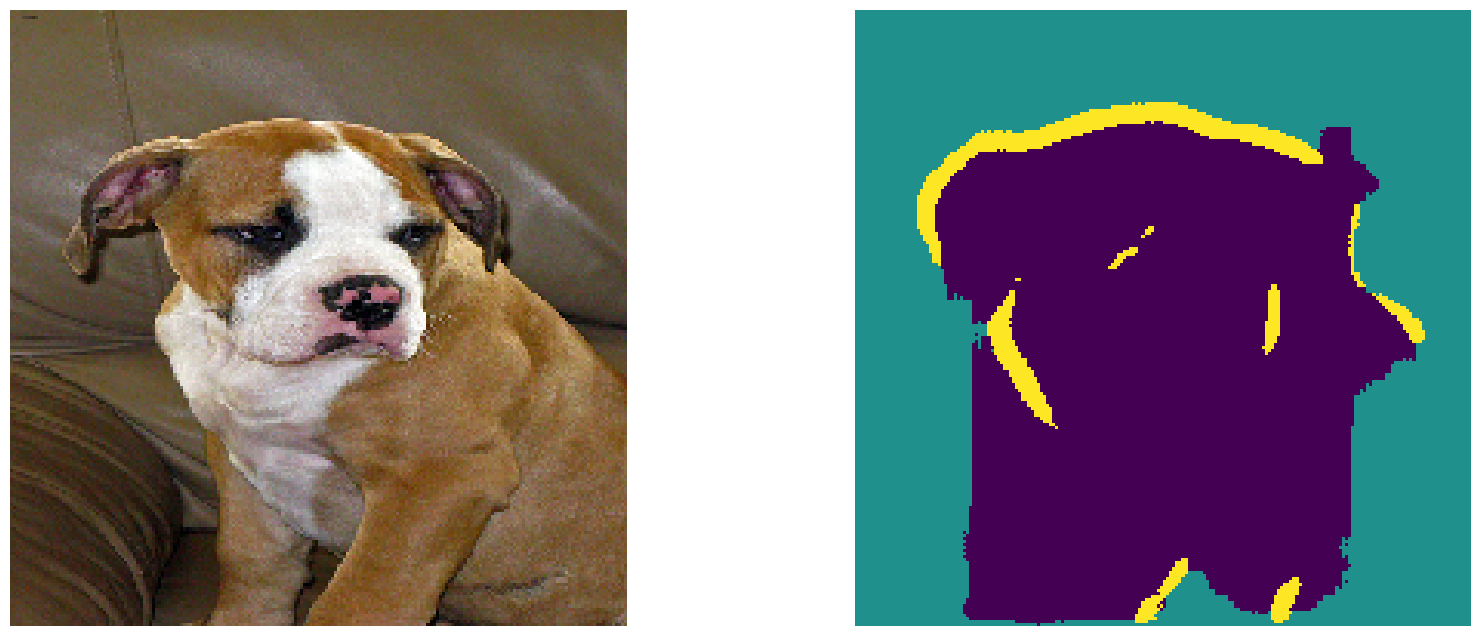

In [148]:
test_idx = random.randint(0, num_labels)
test_img = input_raw[test_idx]
mask = model.predict(np.expand_dims(test_img, 0))[0]
chapter_09.explore_test(test_img, mask)

---
# **Architecture patterns**
---

### <ins />**Definitions**

- **Architecture**
  - Types of layer
  - Number of layer
  - Configuration of layer
  - Arrangment of layer
- **Good architecture**
  - Efficient use of available data 
  - Makes problem simpler for gradient descent
- **Architecture patterns**
  - Residual connection
  - Batch normalization
  - Depthwise separable convolution
- **Modularity, hierarachy, reuse (MHR)**
  - Convnet architectures are structured in pyramid-like repeated group of layers
  - Conv2D
  - Maxpooling
  - Dense
  - Softmax

---
# **Residual connection**
---

##### **Definitions**

- **Vanishing gradients**
    - When there are many layers, the noise starts overwhelming gradient information
    - Backpropagation stops working

- **Residual connection (information shortcut)**
    - It allows gradient informations to propagate noiselessly from top to bottom layers
    - It allows to build models with many layers without vanishing gradient problem
    - It was proposed by ResNet architecture
    - Add input of a layer back to its output

- **Ablation**
    - Convnet architectures are result of continuously trying and keeping what works
    - In the end, remove layer by layer until the network is bare minimum

- **Best practices**
    - When output dim != input dim, use a buffer conv layer
    - With maxpooling, kernel_size=1 and strides=pool_size
    - Without maxpooling, kernel_size=1 and strides=1

##### **Case-1: When there is no maxpooling**

In [110]:
# --------------------------------------
# Without residual connection
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3)(inputs)
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
model1 = keras.Model(inputs=inputs, outputs=outputs, name="no_residual")
# --------------------------------------
# With residual connection
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3)(inputs)
residual = x
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
residual = keras.layers.Conv2D(filters=64, kernel_size=1, strides=1)(residual)  # Buffer layer
outputs = keras.layers.add([outputs, residual])
model2 = keras.Model(inputs=inputs, outputs=outputs, name="with_residual")

In [111]:
model1.summary()

Model: "no_residual"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_107 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_235 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 conv2d_236 (Conv2D)         (None, 30, 30, 64)        18496     
                                                                 
Total params: 19392 (75.75 KB)
Trainable params: 19392 (75.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
model2.summary()

Model: "with_residual"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_108 (InputLayer)      [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_237 (Conv2D)         (None, 30, 30, 32)           896       ['input_108[0][0]']           
                                                                                                  
 conv2d_238 (Conv2D)         (None, 30, 30, 64)           18496     ['conv2d_237[0][0]']          
                                                                                                  
 conv2d_239 (Conv2D)         (None, 30, 30, 64)           2112      ['conv2d_237[0][0]']          
                                                                                      

##### **Case-2: When there is maxpooling**

In [113]:
# --------------------------------------
# Without residual connection
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3)(inputs)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
outputs = keras.layers.MaxPool2D(pool_size=2, padding="same")(x)
model1 = keras.Model(inputs=inputs, outputs=outputs, name="maxpool_no_residual")
# --------------------------------------
# With residual connection
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3)(inputs)
residual = x
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
outputs = keras.layers.MaxPool2D(pool_size=2, padding="same")(x)
residual = keras.layers.Conv2D(filters=64, kernel_size=1, strides=2)(residual)  # Buffer layer
outputs = keras.layers.add([outputs, residual])
model2 = keras.Model(inputs=inputs, outputs=outputs, name="maxpool_with_residual")

In [114]:
model1.summary()

Model: "maxpool_no_residual"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_109 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_240 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 conv2d_241 (Conv2D)         (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                                 
Total params: 19392 (75.75 KB)
Trainable params: 19392 (75.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
model2.summary()

Model: "maxpool_with_residual"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_110 (InputLayer)      [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_242 (Conv2D)         (None, 30, 30, 32)           896       ['input_110[0][0]']           
                                                                                                  
 conv2d_243 (Conv2D)         (None, 30, 30, 64)           18496     ['conv2d_242[0][0]']          
                                                                                                  
 max_pooling2d_24 (MaxPooli  (None, 15, 15, 64)           0         ['conv2d_243[0][0]']          
 ng2D)                                                                        

##### **End-to-end example**
  - TODO

---
# **Batch normalization**
--- 

### <ins />**Definitions**

- **Normalization**
  - Data should be centered around 0 by subtracting the mean from data
  - Data should have unit variance by dividing the data with its std dev

- **Batch normalization**
  - Adaptively normalizing the data as mean and variance change over time during training
  - Even if the data entering the layer is normalized, the output may not be normalized
  - Thats why batch normalization is used

- **Why batch normalization works?**
  - There are several optimization techniques in machine learning without formal reasoning explanation
  - They work empirically in real world (how is known, why is unknown)
  - Example: Batch normalization

- **Best practices**
  - For large models, residual connection and batch normalization should be used
  - When finetuning, layers with batch normalization should be frozen
  - Use activation after normalization (improves utilization of relu)

##### **Case-1: When there is no activation**

In [116]:
# --------------------------------------
# Without batch normalization
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3)(inputs)
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
model1 = keras.Model(inputs=inputs, outputs=outputs, name="no_batch_norm")
# --------------------------------------
# With batch normalization
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(inputs)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
model2 = keras.Model(inputs=inputs, outputs=outputs, name="with_batch_norm")

In [117]:
model1.summary()

Model: "no_batch_norm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_111 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_245 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 conv2d_246 (Conv2D)         (None, 30, 30, 64)        18496     
                                                                 
Total params: 19392 (75.75 KB)
Trainable params: 19392 (75.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [118]:
model2.summary()

Model: "with_batch_norm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_112 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_247 (Conv2D)         (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_8 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_248 (Conv2D)         (None, 30, 30, 64)        18496     
                                                                 
Total params: 19488 (76.12 KB)
Trainable params: 19424 (75.88 KB)
Non-trainable params: 64 (256.00 Byte)
_________________________________________________________________


##### **Case-2: When there is activation**

In [120]:
# --------------------------------------
# Without batch normalization
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(inputs)
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
model1 = keras.Model(inputs=inputs, outputs=outputs, name="activation_no_batch_norm")
# --------------------------------------
# With batch normalization
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation=tf.nn.relu)(x)
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
model2 = keras.Model(inputs=inputs, outputs=outputs, name="activation_with_batch_norm")

In [121]:
model1.summary()

Model: "activation_no_batch_norm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_115 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_253 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 conv2d_254 (Conv2D)         (None, 30, 30, 64)        18496     
                                                                 
Total params: 19392 (75.75 KB)
Trainable params: 19392 (75.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [122]:
model2.summary()

Model: "activation_with_batch_norm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_116 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_255 (Conv2D)         (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_10 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_2 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 conv2d_256 (Conv2D)         (None, 30, 30, 64)        18496     
                                                                 
Total params: 19488 (76.12 KB)
Trainable params: 19424 (75.88 KB)
Non-trainable params: 64 (256.00 Byte)
_

---
# **Depthwise separable convolution**
---

### <ins />**Definitions**

TODO

### <ins />**Example**

##### **With standard convolution**

In [3]:
i = keras.Input(shape=(200, 200, 3))
x = keras.layers.Rescaling(1.0 / 255)(i)
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
o = keras.layers.Conv2D(filters=3, kernel_size=3, padding="same", activation=tf.nn.softmax)(x)
model1 = keras.Model(inputs=i, outputs=o)

##### **With separable convolution**

In [4]:
i = keras.Input(shape=(200, 200, 3))
x = keras.layers.Rescaling(1.0 / 255)(i)
x = keras.layers.SeparableConv2D(filters=32, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
x = keras.layers.SeparableConv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
o = keras.layers.SeparableConv2D(filters=3, kernel_size=3, padding="same", activation=tf.nn.softmax)(x)
model2 = keras.Model(inputs=i, outputs=o)

### <ins />**Comparison**

In [5]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 200, 3)       1731      
                                                                 
Total params: 21123 (82.51 KB)
Trainable params: 21123 (82.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 separable_conv2d (Separabl  (None, 200, 200, 32)      155       
 eConv2D)                                                        
                                                                 
 separable_conv2d_1 (Separa  (None, 200, 200, 64)      2400      
 bleConv2D)                                                      
                                                                 
 separable_conv2d_2 (Separa  (None, 200, 200, 3)       771       
 bleConv2D)                                                      
                                                           